In [1]:
%matplotlib inline
import pandas as pd
from mpl_toolkits.basemap import Basemap
import numpy as np
from utilities import timestamps
from utilities.plotting import equi
from utilities.polygon_selection import get_node_data
from utilities.stats import calc_fmd_stats_with_mc
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])

In [3]:
df.head()

,lon,lat,decimal_year,month,day,mag,depth,hour,minute,second,horizontal_error,depth_error,mag_err
0,139.963333,37.326667,1989.998997,12.0,31.0,1.9,6.4,15.0,12.0,50.900002,1.752955,3.7,NaN
1,137.620000,34.813333,1989.999023,12.0,31.0,1.4,28.0,15.0,26.0,39.499997,1.062217,1.3,NaN
2,142.820000,41.473333,1989.999336,12.0,31.0,2.7,35.0,18.0,11.0,2.200001,6.021544,NaN,NaN
3,137.648333,35.233333,1989.999479,12.0,31.0,1.3,14.3,19.0,25.0,57.299998,0.822034,1.5,NaN
4,140.273333,34.355000,1989.999492,12.0,31.0,2.3,51.0,19.0,32.0,44.399997,3.503555,NaN,NaN


In [4]:
df['timestamp'] = df.decimal_year.apply(timestamps.convert_decimal_year_to_numpy_datetime64)

In [5]:
foreshock_time = '2016-04-14 12:26:00'
mainshock_time = '2016-04-15 16:24:28'

df = df[df.timestamp >= '2001-10-01 00:00:00']
df = df[df.timestamp < foreshock_time]
df = df[df.depth <= 40]

In [6]:
df = df.set_index('timestamp')

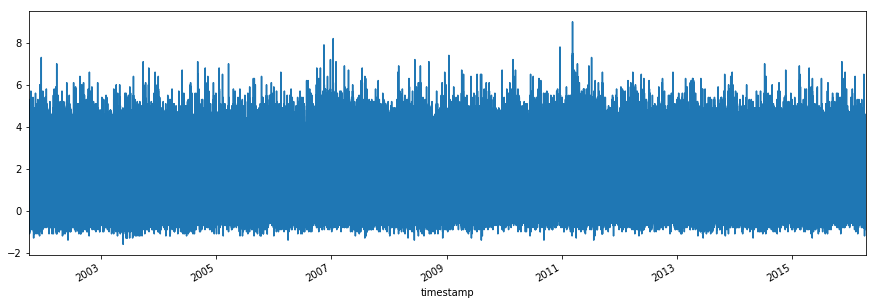

In [7]:
df.mag.plot(figsize=(15,5))

In [8]:
df.horizontal_error.describe()

count    1.612054e+06
mean     8.874616e-01
std      1.092098e+00
min      0.000000e+00
25%      3.184243e-01
50%      4.821290e-01
75%      1.099528e+00
max      3.650326e+01
Name: horizontal_error, dtype: float64

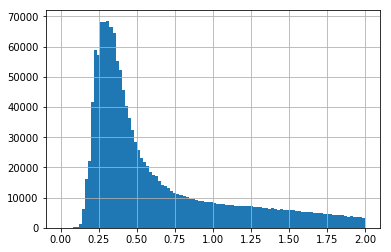

In [9]:
df.horizontal_error.hist(bins=100, range=(0,2))

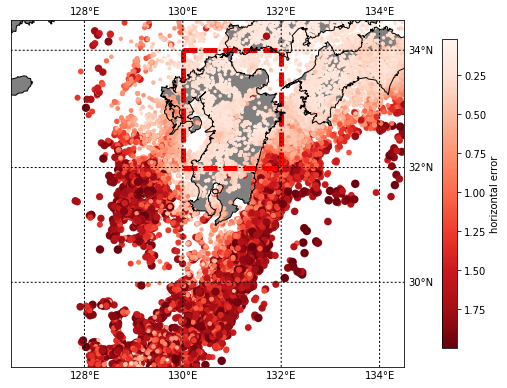

In [183]:
fig, ax = plt.subplots(1, figsize=(8,8))

m = Basemap(projection='merc'
           ,llcrnrlat=28.5
           ,urcrnrlat=34.5
           ,llcrnrlon=126.5
           ,urcrnrlon=134.5
           ,resolution='i'
           ,area_thresh=1000
           ,ax=ax)

labels = np.arange(0,180,2)
m.drawparallels(labels, labels=labels)
m.drawmeridians(labels, labels=labels)

m.drawcoastlines()
m.fillcontinents(color='gray', zorder=0)

# # data = df[(df.mag > 2.5) & df.lat.between(32,34) & df.lon.between(130,132)]
d = df[(df.mag > 1)].copy()
d = d[d.lat.between(28.5, 34.5) & d.lon.between(126.5, 134.5)]
d = d[d.horizontal_error <= 2.0]


x, y = m(d.lon.values, d.lat.values)

cbar = ax.scatter(x, y, c=d.horizontal_error.values, s=10*np.exp(d.horizontal_error.values), edgecolor='None'
                  , cmap='Reds')
c1 = fig.colorbar(cbar, label='horizontal error',fraction=0.0346, pad=0.084)
c1.ax.invert_yaxis()

# sizes = np.exp([3,4,5,6,7])
# label_plot = [ax.scatter([],[], s=s, edgecolors='black', color='white', alpha=0.5) for s in sizes]
# labels = [x for x in range(3,11)]
# ax.legend(label_plot, labels, ncol=10, frameon=True, fontsize=12, handlelength=0.75, loc='upper left'
#         , borderpad = 1.,handletextpad=0.95, title='Magnitude Size', scatterpoints = 1
#         , bbox_to_anchor=(0.18,0.0115))

# equi(m, 131, 33, 75, lw=5, color='green')
# equi(m, 132, 32, 50, lw=2)
# equi(m, 130, 34, 50, lw=2, color='red')

# def plot_line_on_map(m, ax, point_a, point_b, **kwargs):
#     x, y = ([point_a[0], point_b[0]], [point_a[1], point_b[1]])
#     ax.plot(x, y, kwargs)

# plot_line_on_map(m, ax, (130, 132), (34, 34))
    
from utilities.plotting import draw_screen_poly

draw_screen_poly(lats=[34,34,32,32], lons=[130,132,132,130], m=m, ax=ax)

# m.plot((130, 132), (34, 34), lw=5, color='green')
# m.plot((130, 130), (34, 32), lw=5, color='green')

In [168]:
def get_cumdist(data):
    hist, edges = np.histogram(a=data, bins=100, range=(0,10))
    chist = np.cumsum(hist[::-1])
    return edges, hist, chist

def plot_data_with_fit_line(ax, raw_data, chist, radius, **kwargs):
    a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    label = radius + ', b={b}, mc={mc}, n={n}'.format(b=round(b,4),mc=mc,n=n)
    ax.scatter(chist[0][::-1][:-1], chist[2], label=label, **kwargs)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(raw_data.mag)
    x = np.arange(0, 10, 0.1)
    y = 10**(a - b * x)
    ax.plot(x, y, color='black')

In [169]:
def generate_b_based_on_location_uniform_error(df, location, radius):
    err_df = df.copy()
    err_df['lon'] = err_df['lon'] + np.random.uniform(-1, 1) * err_df['hz_err_deg']
    err_df['lat'] = err_df['lat'] + np.random.uniform(-1, 1) * err_df['hz_err_deg']
    node_df = get_node_data(node=location, radius=radius, data=err_df)
    a, b, bstd, n, mc = calc_fmd_stats_with_mc(node_df.mag)
    return a, b, bstd, n, mc

def generate_b_based_on_location_mag_normal_error(df, location, radius):
    """
    Assumes a dataframe with columns:
    
    lon        : longitude
    lat        : latitude
    mag        : magnitude
    hz_err_deg : error in the horizontal plane
    
    assumes a 0.1 standard deviation of magnitude error
    assumes all data comes from a normal distribution    
    """
    err_df = df.copy()
    err_df['lon'] = np.random.normal(df['lon'].values, df['hz_err_deg'].values+0.001)
    err_df['lat'] = np.random.normal(df['lat'].values, df['hz_err_deg'].values+0.001)
    err_df['mag'] = np.random.normal(df['mag'], 0.1)
    node_df = get_node_data(node=location, radius=radius, data=err_df)
    a, b, bstd, n, mc = calc_fmd_stats_with_mc(node_df.mag)
    return a, b, bstd, n, mc

def get_catalog_shifted_by_location_mag_normal_error(df):
    err_df = df.copy()
    err_df['lon'] = np.random.normal(df['lon'].values, df['hz_err_deg'].values+0.001)
    err_df['lat'] = np.random.normal(df['lat'].values, df['hz_err_deg'].values+0.001)
    err_df['mag'] = np.random.normal(df['mag'], 0.1)
    return err_df

In [170]:
np.random.normal(df['lon'].values, df['hz_err_deg'].values+0.001)

array([ 140.92561977,  143.28975382,  147.48149076, ...,  142.15735253,
        142.10624452,  142.14993474])

In [171]:
np.random.normal([0,2,3], [1,0.2,0.3])

array([ 0.83769933,  1.62036376,  2.75714868])

In [172]:
df['hz_err_deg'].dropna().count()

1612054

In [173]:
df['hz_err_deg'].count()

1612054

In [174]:
df['hz_err_deg'] = df['horizontal_error'] / 111.113

# Kumamoto region b-value lon/lat/mag error

In [175]:
df_kuma = df[df.lon.between(130,132) & df.lat.between(30,32)].copy()
df_kuma = df[df.mag >= 0.5]

In [176]:
b_kuma = [generate_b_based_on_location_mag_normal_error(df=df_kuma, location=(131, 31), radius=75) for x in range(10000)]

In [177]:
bkuma10000df = pd.DataFrame(np.array(b_kuma), columns=['a','b','bstd','n','mc'])
bkuma10000df.describe()

,a,b,bstd,n,mc
count,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000
mean,4.905384,0.842947,5.219839e-15,6305.751500,1.313288
std,0.020343,0.013465,3.915009e-15,626.393762,0.054260
min,4.810921,0.781939,1.675545e-19,4433.000000,1.130000
25%,4.893728,0.835163,2.110681e-15,5908.000000,1.280000
50%,4.907080,0.843976,4.395649e-15,6304.000000,1.310000
75%,4.919201,0.851991,7.491386e-15,6684.000000,1.350000
max,4.961342,0.880281,2.850455e-14,8457.000000,1.490000


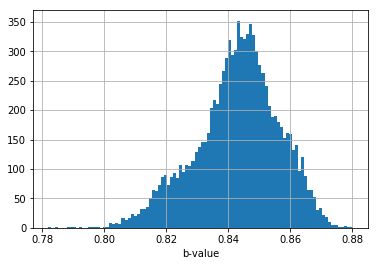

In [186]:
ax = bkuma10000df.b.hist(bins=100)
ax.set_xlabel('b-value')

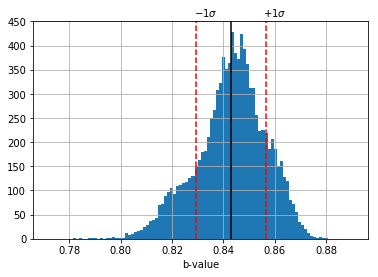

In [196]:
ax = bkuma10000df.b.hist(bins=100, range=(bkuma10000df.b.min()-0.01,bkuma10000df.b.max()+0.01))
lowsigma = bkuma10000df.b.mean() - bkuma10000df.b.std()
highsigma = bkuma10000df.b.mean() + bkuma10000df.b.std()
avg = bkuma10000df.b.mean()
ax.plot((lowsigma,lowsigma), (0, 450), color='red', linestyle='--')
ax.plot((highsigma,highsigma), (0, 450), color='red', linestyle='--')
ax.plot((avg, avg), (0,450), color='black')
ax.set_ylim(0,450)
ax.set_xlabel('b-value')
# ax.set_xticks(np.arange(0,1.5,0.1))
ax.text(x=lowsigma-0.001, y=460, s=r'$-1\sigma$')
ax.text(x=highsigma-0.001, y=460, s=r'$+1\sigma$')

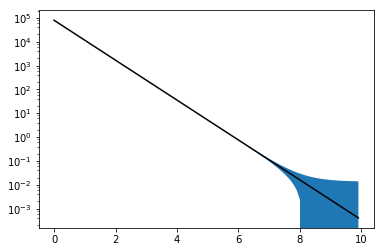

In [202]:
fig, ax = plt.subplots()
x = np.arange(0, 10, 0.1)
y = 10**(a - b * x)
ax.plot(x, y, color='black')
ax.fill_between(x, (y-bkuma10000df.b.std()), (y+bkuma10000df.b.std()))
ax.set_yscale('log')


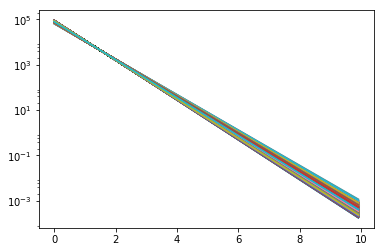

In [198]:
fig, ax = plt.subplots()

ayes = bkuma10000df.a.values
bees = bkuma10000df.b.values
x = np.arange(0, 10, 0.1)

for a,b in zip(ayes, bees):
    y = 10**(a - b * x)
    ax.plot(x, y, color=)

ax.set_yscale('log')

# 4 locations from before (low/high b, max slip, hypocenter)

In [12]:
max_slip = (130.9372, 32.84189)
fm_main = (130.763, 32.7545)#, 128, 74, -14)
high_b = (131.25, 33.15,)
low_b = (130.5, 32.5)

In [13]:
df_min = df[df.mag > 1.5].copy()

In [14]:
get_node_data(node=low_b, radius=15, data=df_min).describe()

,lon,lat,decimal_year,month,day,mag,depth,hour,minute,second,horizontal_error,depth_error,mag_err,distance
count,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,228.000000,0.0,229.000000
mean,130.558514,32.479783,2008.394681,6.676856,15.633188,2.108297,9.827162,11.986900,29.353712,29.347947,0.335678,1.168070,NaN,8.371768
std,0.049109,0.050904,4.357228,3.582418,8.428541,0.531772,2.355899,7.224763,16.236783,18.212496,0.060563,0.376498,NaN,3.203716
min,130.427833,32.362333,2001.769935,1.000000,1.000000,1.600000,0.000000,0.000000,0.000000,0.210001,0.169813,0.490000,NaN,2.326599
25%,130.530000,32.447500,2004.874702,4.000000,8.000000,1.700000,8.490000,5.000000,17.000000,12.429998,0.287997,0.930000,NaN,5.487985
50%,130.560167,32.490833,2007.223757,6.000000,15.000000,1.900000,9.660000,12.000000,28.000000,29.520001,0.325487,1.085000,NaN,7.917089
75%,130.583500,32.510833,2012.150988,10.000000,23.000000,2.400000,11.650000,19.000000,42.000000,46.159996,0.371352,1.352500,NaN,11.257706
max,130.667000,32.594333,2016.262592,12.000000,31.000000,4.800000,15.700000,23.000000,59.000000,59.630003,0.586807,2.800000,NaN,14.791102


In [16]:
# b_hypo = []
# for r in range(100):
#     loc_err_df = df.copy()
#     loc_err_df['lon'] = loc_err_df['lon'] + np.random.uniform(-1,1) * loc_err_df['horizontal_error']
#     loc_err_df['lat'] = loc_err_df['lat'] + np.random.uniform(-1,1) * loc_err_df['horizontal_error']
#     node_df = get_node_data(node=fm_main, radius=15, data=loc_err_df)
#     a, b, bstd, n, mc = calc_fmd_stats_with_mc(node_df.mag)
#     b_hypo.append(b)

In [18]:
# %timeit generate_b_based_on_location_error(df=df, location=fm_main, radius=15)

# hypocenter b-value distribution

In [19]:
b10000samples = [generate_b_based_on_location_error(df=df[df.mag>1.5], location=fm_main, radius=15) for x in range(10000)]

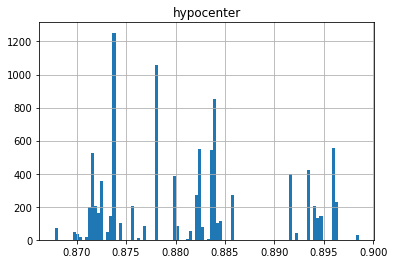

In [20]:
b10000df = pd.DataFrame(np.array(b10000samples), columns=['a','b','bstd','n','mc'])
ax = b10000df.b.hist(bins=100)
ax.set_title('hypocenter')

In [33]:
b10000df.describe()

,a,b,bstd,n,mc
count,10000.000000,10000.000000,1.000000e+04,10000.000000,1.000000e+04
mean,4.108499,0.881457,3.661434e-15,332.569100,1.800000e+00
std,0.015472,0.008054,3.146158e-16,1.575333,3.379688e-13
min,4.076575,0.867793,2.855406e-15,327.000000,1.800000e+00
25%,4.094074,0.873853,3.417427e-15,332.000000,1.800000e+00
50%,4.109476,0.880639,3.635580e-15,333.000000,1.800000e+00
75%,4.114836,0.884478,3.966884e-15,334.000000,1.800000e+00
max,4.139817,0.898540,4.235956e-15,336.000000,1.800000e+00


In [21]:
b10000df.describe()

,a,b,bstd,n,mc
count,10000.000000,10000.000000,1.000000e+04,10000.000000,1.000000e+04
mean,4.108499,0.881457,3.661434e-15,332.569100,1.800000e+00
std,0.015472,0.008054,3.146158e-16,1.575333,3.379688e-13
min,4.076575,0.867793,2.855406e-15,327.000000,1.800000e+00
25%,4.094074,0.873853,3.417427e-15,332.000000,1.800000e+00
50%,4.109476,0.880639,3.635580e-15,333.000000,1.800000e+00
75%,4.114836,0.884478,3.966884e-15,334.000000,1.800000e+00
max,4.139817,0.898540,4.235956e-15,336.000000,1.800000e+00


# low-bvalue

In [22]:
low_b_10000_samples = [generate_b_based_on_location_error(df=df[df.mag>1.5]
                                                          , location=low_b, radius=15) for x in range(10000)]

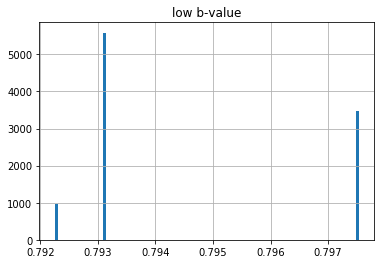

In [23]:
low_b_10000_samples = pd.DataFrame(np.array(low_b_10000_samples), columns=['a','b','bstd','n','mc'])
ax = low_b_10000_samples.b.hist(bins=100)
ax.set_title('low b-value')

# max slip

In [24]:
max_slip_10000_samples = [generate_b_based_on_location_error(df=df[df.mag>1.5]
                                                          , location=max_slip, radius=15) for x in range(10000)]

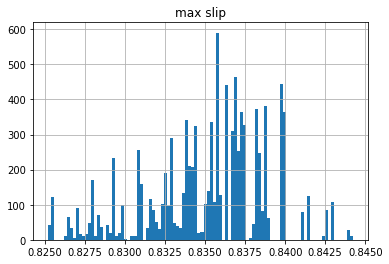

In [25]:
max_slip_10000_samples = pd.DataFrame(np.array(max_slip_10000_samples), columns=['a','b','bstd','n','mc'])
ax = max_slip_10000_samples.b.hist(bins=100)
ax.set_title('max slip')

# high b value

In [26]:
high_b_10000_samples = [generate_b_based_on_location_error(df=df[df.mag>1.5]
                                                          , location=high_b, radius=15) for x in range(10000)]

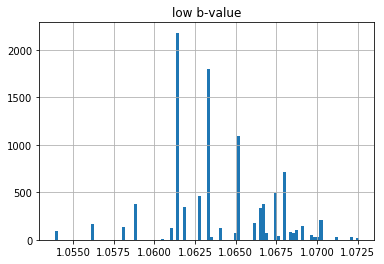

In [27]:
high_b_10000_samples = pd.DataFrame(np.array(high_b_10000_samples), columns=['a','b','bstd','n','mc'])
ax = high_b_10000_samples.b.hist(bins=100)
ax.set_title('low b-value')

In [ ]:
# err_df = df.copy()

# %timeit err_df['lon'] = err_df['lon'] + np.random.uniform(-1, 1) * err_df['hz_err_deg']


In [ ]:
# err_df['hz_err_deg'].describe()

In [ ]:
# pd.DataFrame(b_hypo).hist()

In [ ]:
# def generate_b_based_on_location_error(df, samples, location, radius):
#     b_hypo = []
#     for r in range(samples):
#         loc_err_df = df.copy()
#         loc_err_df = get_node_data(node=location, radius=radius, data=loc_err_df)
#         loc_err_df['lon'] = loc_err_df['lon'] + np.random.uniform(-1,1) * loc_err_df['hz_err_deg']
#         loc_err_df['lat'] = loc_err_df['lat'] + np.random.uniform(-1,1) * loc_err_df['hz_err_deg']
# #         node_df = get_node_data(node=location, radius=radius, data=loc_err_df)
#         a, b, bstd, n, mc = calc_fmd_stats_with_mc(loc_err_df.mag)
#         b_hypo.append(b)
#     return np.array(b_hypo)

In [ ]:
# b_hypo

In [ ]:
# hypo_b = generate_b_based_on_location_error(df=df, samples=10000, location=fm_main, radius=15)

In [ ]:
# hypo_b

In [ ]:
# (1.6/10*10000)/60